# TIME SERIES

In [1]:
## import the necessary libraries for time series modelling
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
## read in train and test dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
## checking for any null values
print('train_df')
print(train_df.isnull().sum())
print('\ntest_df')
print(test_df.isnull().sum())

train_df
Date     0
T        0
RH       0
Gas      0
Value    0
dtype: int64

test_df
id      0
Date    0
T       0
RH      0
Gas     0
dtype: int64


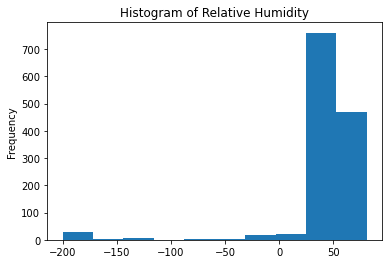

In [4]:
## check distribution in 'RH' column
train_df['RH'].plot(kind='hist')
plt.title("Histogram of Relative Humidity")
plt.show()

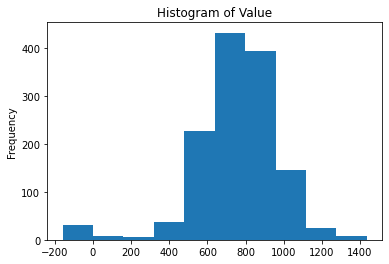

In [5]:
## check distribution in 'Value' column
train_df['Value'].plot(kind='hist')
plt.title("Histogram of Value")
plt.show()

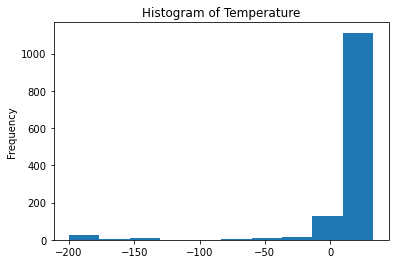

In [6]:
## check distribution in 'Value' column
train_df['T'].plot(kind='hist')
plt.title("Histogram of Temperature")
plt.show()

### Insights From Data Exploration:
##### ‎
##### Although there are no null values within the dataset, the histograms plotted show that there are some nonsense values that have to be cleaned. 
##### ‎
##### The Relative Humidity column (RH) and Value column contains values < 0, which although are not physically possible, it is possible that these values are obtained during computation of these values and hence might be real data. The dataset only has around 1000+ rows, and as a result, we will not be imputing any of these values.
##### ‎
##### However, there also seems to be some extreme values in the Temperature column (T) such as -200 degrees. These values will be handled in the next step as they do not seem reasonable.
### ‎

### Data Preprocessing

In [3]:
## handling irregular values in train data
train_df['T'] = np.where(train_df['T']<-50, np.nan, train_df['T'])
train_df['T'] = train_df['T'].fillna(method='ffill')

In [4]:
## handling irregular values in test data
test_df['T'] = np.where(test_df['T']<-50, np.nan, test_df['T'])
test_df['T'] = test_df['T'].fillna(method='ffill')

In [5]:
## setting the index as Date (train_df)
train_df.index = pd.to_datetime(train_df.Date , format = '%d/%m/%Y')
train_df.drop('Date',axis = 1, inplace = True)
train_df.head()

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667


In [6]:
## setting the index as Date (test_df)
test_df.index = pd.to_datetime(test_df.Date , format = '%d/%m/%Y')
test_df.drop(['Date','id'],axis = 1, inplace = True)
test_df.head()

,T,RH,Gas
Date,,,
2017-02-06,6.616667,51.734375,CO
2017-02-07,7.613194,43.930903,CO
2017-02-08,7.252083,50.966667,CO
2017-02-09,7.473611,50.166319,CO
2017-02-10,5.571875,46.604167,CO


In [9]:
## identify the number of incorrect values in the train data 

train_rh = train_df['RH']
rh_count = train_rh[train_rh < 0].count()

train_value = train_df['Value']
value_count = train_value[train_value < 0].count()

train_temp = train_df['T']
temp_count = train_temp[train_temp < -50].count()

print('rh count: ' + str(rh_count))
print('value count: ' + str(value_count))
print('temperature count: ' + str(temp_count))
print('total rows: ' + str(train_df['RH'].count()))

rh count: 64
value count: 31
temperature count: 56
total rows: 1312


In [10]:
test_rh = test_df['RH']
rh_count = test_rh[test_rh < 0].count()

test_temp = test_df['T']
temp_count = test_temp[test_temp < -50].count()

print('rh count: ' + str(rh_count))
print('temperature count: ' + str(temp_count))
print('total rows: ' + str(test_df['RH'].count()))

rh count: 16
temperature count: 16
total rows: 252


### Data Preprocessing:
##### ‎
##### First the index of the train and test dataframes are set as Date
##### ‎
##### Next, the values < -50 are imputed using forward fill. As there are a few number of rows in this time series, little data preprocessing is done.
### ‎

## CO GAS

In [7]:
## extract CO gas only
CO = train_df.loc[train_df['Gas'] == "CO"]
CO = CO.drop(columns=['Gas'])
CO.head()

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,1053.200000
2016-03-16,9.833333,64.069791,995.250000
2016-03-17,11.292708,51.107292,1025.250000
2016-03-18,12.866319,51.530903,1064.444444
2016-03-19,16.016667,48.843750,1088.741667


### Decomposition Plot

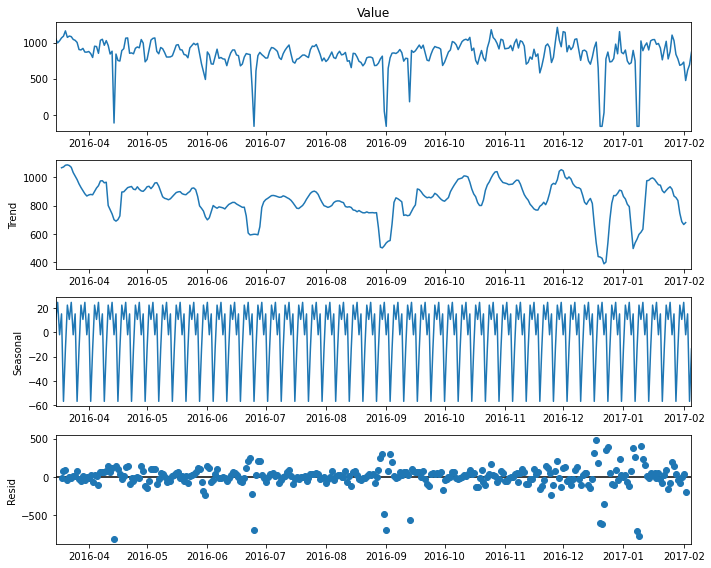

In [9]:
## CO gas decomposition plot
result = seasonal_decompose(CO['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

#### Seasonal ACF and PACF Plots

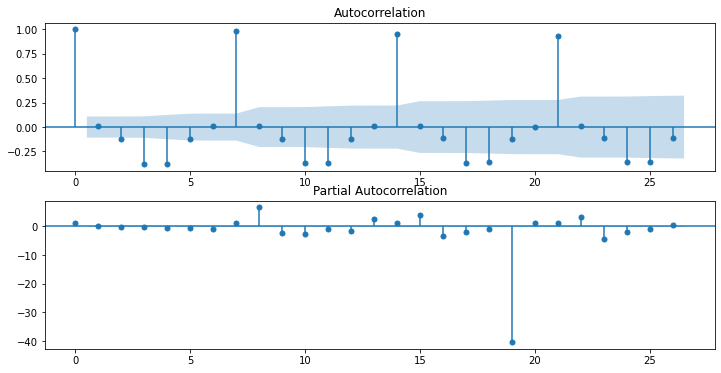

In [10]:
## CO gas seasonal ACF and PCAF plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

#### From the first decomposition plot, we can see that there is no trend, and there seems to be seasonality in the time series.
##### ‎
#### By plotting the seasonal ACF plot, we are able to tell that there is seasonality in the data, with a period of every 7 days
##  ‎

### Simple Moving Average Model

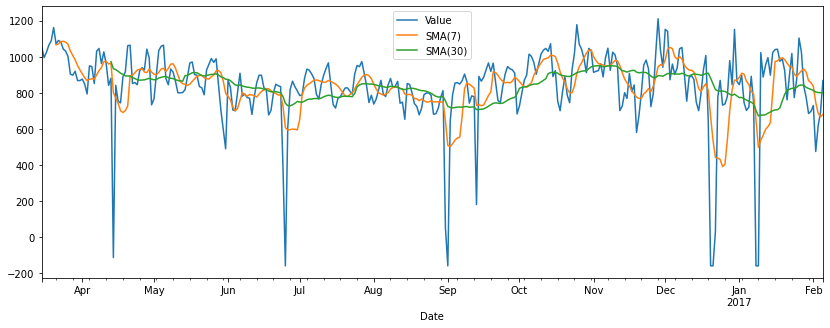

In [11]:
## Simple Moving Average Model
CO_SMA = CO['Value']
ax = CO_SMA.plot(figsize=(14, 5))
CO_SMA.rolling(window=7).mean().plot(ax=ax)
CO_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)'])
plt.show()

#### As the SMA model is a simple model that predicts purely based off the average values from the past, it does not handle the seasoinality and large dips in the time series.
##### ‎
#### As shown from the plot above, the predicted values from a SMA 7-day model and a SMA 30-day model do not fit very well to the actual values of the time series
## ‎

### Holt-Winters Exponential Smoothing Model

In [76]:
## split into train and test data
train_data = CO[CO.index<='2016-08-20']
test_data = CO[CO.index>'2016-08-20']
train_data = train_data.drop(columns=['T', 'RH'])
test_data = test_data.drop(columns=['T', 'RH'])

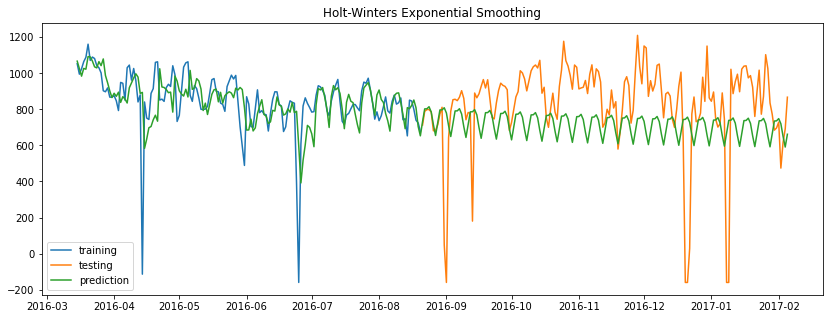

,MAE,MAPE,MSE,RMSE
0,88.522925,0.182291,21954.521387,148.170582


In [13]:
es_model = HWES(train_data, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
pred1 = es_model.predict(start='2016-03-15', end='2017-02-05')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

train_mae = mean_absolute_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mape = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mse = mean_squared_error(train_data, pred1[pred1.index<'2016-08-21'])
train_rmse = np.sqrt(train_mse)

metrics = []
metrics.append(train_mae)
metrics.append(train_mape)
metrics.append(train_mse)
metrics.append(train_rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

#### As compared to the SMA model, the HWES model takes into consideration seasonality, but does not seen to handle it very well.
##### ‎
#### As shown from the plot above, the predicted values are somewhat following the same trend as the train data, however upon predicting on the test, it creates a simple repeating pattern that does not fit the test data at all. Although it possesses a decent RMSE score, the model clearly does not fit well to the data.
##  ‎

In [17]:
## identify min and max index in the dataframe
index = CO.index
mindex = index.min()
maxdex = index.max()

print("min index: " + str(mindex))
print("max index: " + str(maxdex))

min index: 2016-03-15 00:00:00
max index: 2017-02-05 00:00:00


In [183]:
## checking for stationarity
CO1 = CO[CO.index<='2016-08-20']
CO2 = CO[CO.index>'2016-08-20']
CO1Mean = CO1['Value'].mean()
CO2Mean = CO2['Value'].mean()
CO1Var = CO1['Value'].var()
CO2Var = CO2['Value'].var()
print(f'Group 1 Mean: {CO1Mean} | Group 2 Mean: {CO2Mean}')
print(f'Group 1 Var: {CO1Var} | Group 2 Var: {CO2Var}')

Group 1 Mean: 849.2400943364785 | Group 2 Mean: 832.4390861412428
Group 1 Var: 25955.824472213404 | Group 2 Var: 57115.78346891563


In [184]:
## conduct augmented dicky fuller test
pval = adfuller(CO['Value'])
print('p-val of CO Gas: %f' % pval[1])

p-val of CO Gas: 0.000000


#### By checking the mean and standard deviation of the data, we can see that although the means of the 2 groups are very similar, the variances are significantly different.
##### ‎
#### Upon using the Augmented Dickey-Fuller test, we can see that it has a p-value of 0, and hence the time series is considered stationary
##  ‎

### ACF and PACF Plots to obtain p,d,q values

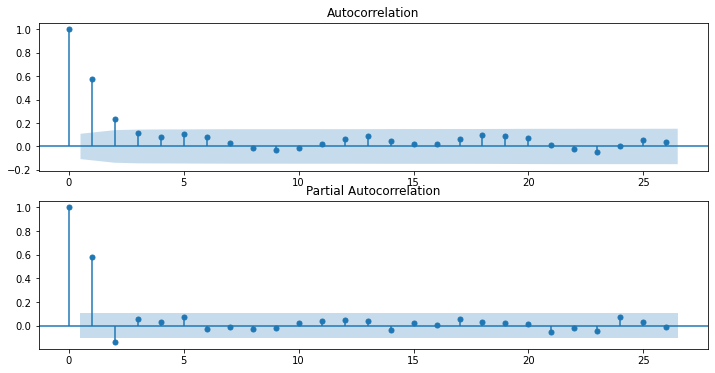

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(CO['Value'], ax=ax[0])
plot_pacf(CO['Value'], ax=ax[1])
plt.show()

#### From the PACF plot, p=1
#### From the ACF plot, q=1
#### Since the time series is stationary, no differencing is required and hence d=0
##  ‎

### SARIMAX

In [15]:
exogCO = CO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(CO['Value'], order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogCO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1863.120
Date:                           Wed, 10 Aug 2022   AIC                           3740.241
Time:                                   19:46:43   BIC                           3766.792
Sample:                               03-15-2016   HQIC                          3750.834
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              1.1326      0.490      2.311      0.021       0.172       2.093
RH             4.1912      0.113     36.981      0.000       3.969       4.413
ar.L1          0.6353      0.052     12.223      0.000       0.533       0.737
ma.L1          0.2193      0.064      3.425      0.001       0.094       0.345
ar.S.L7        0.9992      0.001   1496.364      0.000       0.998       1.001
ma.S.L7       -0.9192      0.032    -28.389      0.000      -0.983      -0.856
sigma2      4547.4055    335.918     13.537      0.000    3889.019    5205.792
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 5.41
Prob(Q):                              0.63   Prob(JB):                         0.07
Heteroskedasticity (H):               1.36   Skew:                            -0.10
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(CO['Value'], pred)
mape = mean_absolute_percentage_error(CO['Value'], pred)
mse = mean_squared_error(CO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,57.044302,0.072242,7202.718259,84.86883


### SARIMAX GridSearch

In [10]:
## split into train and test data
train_data = CO[CO.index<='2016-08-20']
test_data = CO[CO.index>'2016-08-20']

In [22]:
## define params
orders = [(1,0,1),(1,0,2),(1,0,3),
          (1,1,1),(1,1,2),(1,1,3),
          (2,0,1),(2,0,2),(2,0,3),
          (2,1,1),(2,1,2),(2,1,3)]

seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,0,3,7),
                   (1,1,1,7),(1,1,2,7),(1,1,3,7),
                   (2,0,1,7),(2,0,2,7),(2,0,3,7),
                   (2,1,1,7),(2,1,2,7),(2,1,3,7)]

trainExog = train_data[['T','RH']]
predExog = test_data[['T','RH']]

In [23]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order), str(seasonal_order)
             )
        try:
            arima_model = SARIMAX(train_data['Value'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n', exog=trainExog).fit()
        
            pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("")

trying (1, 0, 1) (1, 0, 1, 7)
trying (1, 0, 1) (1, 0, 2, 7)
trying (1, 0, 1) (1, 0, 3, 7)
trying (1, 0, 1) (1, 1, 1, 7)
trying (1, 0, 1) (1, 1, 2, 7)
trying (1, 0, 1) (1, 1, 3, 7)
trying (1, 0, 1) (2, 0, 1, 7)
trying (1, 0, 1) (2, 0, 2, 7)
LU decomposition error.
trying (1, 0, 1) (2, 0, 3, 7)
trying (1, 0, 1) (2, 1, 1, 7)
trying (1, 0, 1) (2, 1, 2, 7)
trying (1, 0, 1) (2, 1, 3, 7)
trying (1, 0, 2) (1, 0, 1, 7)
trying (1, 0, 2) (1, 0, 2, 7)
trying (1, 0, 2) (1, 0, 3, 7)
trying (1, 0, 2) (1, 1, 1, 7)
trying (1, 0, 2) (1, 1, 2, 7)
trying (1, 0, 2) (1, 1, 3, 7)
trying (1, 0, 2) (2, 0, 1, 7)
trying (1, 0, 2) (2, 0, 2, 7)
trying (1, 0, 2) (2, 0, 3, 7)
trying (1, 0, 2) (2, 1, 1, 7)
trying (1, 0, 2) (2, 1, 2, 7)
trying (1, 0, 2) (2, 1, 3, 7)
trying (1, 0, 3) (1, 0, 1, 7)
trying (1, 0, 3) (1, 0, 2, 7)
trying (1, 0, 3) (1, 0, 3, 7)
trying (1, 0, 3) (1, 1, 1, 7)
trying (1, 0, 3) (1, 1, 2, 7)
trying (1, 0, 3) (1, 1, 3, 7)
trying (1, 0, 3) (2, 0, 1, 7)
trying (1, 0, 3) (2, 0, 2, 7)
trying (1, 0, 3)

In [24]:
CO_metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
CO_metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
CO_metrics_df_rmse = metrics_df.sort_values('RMSE_test')
CO_metrics_df_aic = metrics_df.sort_values('AIC')

In [25]:
CO_metrics_df_rmse

,model,RMSE_train,RMSE_test,AIC
10,"(1, 0, 1),(2, 1, 3, 7)",202.52,103.15,1694.643373
99,"(2, 0, 3),(2, 0, 2, 7)",96.67,108.61,2016.540930
91,"(2, 0, 2),(2, 1, 2, 7)",202.62,118.33,1694.217563
74,"(2, 0, 1),(1, 1, 1, 7)",203.54,122.21,1690.003309
75,"(2, 0, 1),(1, 1, 2, 7)",203.53,122.39,1690.058914
...,...,...,...,...
83,"(2, 0, 2),(1, 0, 3, 7)",99.27,771.63,1814.877987
82,"(2, 0, 2),(1, 0, 2, 7)",100.25,827.38,1815.647034
87,"(2, 0, 2),(2, 0, 1, 7)",98.91,1065.27,1806.229016
11,"(1, 0, 2),(1, 0, 1, 7)",3135.20,5047.93,16.000000


In [26]:
CO_metrics_df_aic

,model,RMSE_train,RMSE_test,AIC
11,"(1, 0, 2),(1, 0, 1, 7)",3135.20,5047.93,16.000000
72,"(2, 0, 1),(1, 0, 2, 7)",3830.11,5422.73,18.000000
50,"(1, 1, 2),(1, 1, 1, 7)",102.87,304.92,1675.139676
106,"(2, 1, 1),(1, 1, 1, 7)",102.84,302.64,1675.377127
38,"(1, 1, 1),(1, 1, 1, 7)",103.28,306.29,1675.731468
...,...,...,...,...
30,"(1, 0, 3),(2, 0, 2, 7)",126.72,493.70,2028.390010
88,"(2, 0, 2),(2, 0, 2, 7)",113.53,654.03,2032.249395
7,"(1, 0, 1),(2, 0, 3, 7)",111.69,554.78,2040.986163
89,"(2, 0, 2),(2, 0, 3, 7)",123.54,347.31,2077.229415


#### Before fitting the data into the SARIMAX model, we first perform a simple gridsearch to identify the best combination of order and seasonal_order for the model. We then obtain the train RMSE, test RMSE and AIC scores and append them to a metrics dataframe and sorted by RMSE and AIC respectively.
##### ‎
#### From the two sorted dataframes, we can see that orders poossesing a low RMSE have a high AIC, while orders possessing a low AIC have a high RMSE. By comparing the two dataframes, we are able to choose a model with the best balance of RMSE and AIC scores.
##  ‎

### SARIMAX - Ideal Parameters

Since this data has seasonality, we will use SARIMAX instead of ARIMA

In [11]:
exogCO = CO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(CO['Value'], order=(1, 0, 1),
                      seasonal_order=(2, 1, 3, 7), trend='n',exog=exogCO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2, 3], 7)   Log Likelihood               -1808.820
Date:                                   Fri, 12 Aug 2022   AIC                           3637.640
Time:                                           18:50:03   BIC                           3675.355
Sample:                                       03-15-2016   HQIC                          3652.699
                                            - 02-05-2017                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.8534      0.531      1.606      0.108      -0.188       1.895
RH             4.1260      0.104     39.708      0.000       3.922       4.330
ar.L1          0.5835      0.066      8.866      0.000       0.455       0.712
ma.L1          0.2094      0.072      2.890      0.004       0.067       0.351
ar.S.L7       -0.0885      0.068     -1.297      0.195      -0.222       0.045
ar.S.L14      -0.9836      0.039    -25.079      0.000      -1.060      -0.907
ma.S.L7       -0.8858      0.084    -10.497      0.000      -1.051      -0.720
ma.S.L14       0.9509      0.247      3.854      0.000       0.467       1.434
ma.S.L21      -0.9156      0.207     -4.414      0.000      -1.322      -0.509
sigma2      4220.7050    757.249      5.574      0.000    2736.524    5704.886
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.71   Prob(JB):                         0.41
Heteroskedasticity (H):               1.50   Skew:                            -0.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

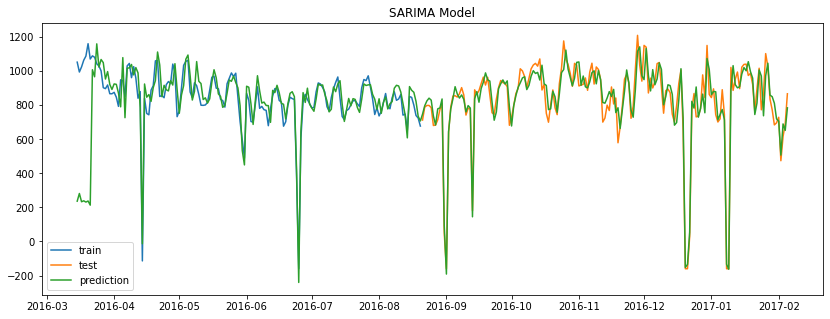

In [12]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data['Value'], label='train')
ax.plot(test_data['Value'], label='test')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [13]:
mae = mean_absolute_error(CO['Value'], pred)
mape = mean_absolute_percentage_error(CO['Value'], pred)
mse = mean_squared_error(CO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,69.176372,0.087895,19218.203638,138.629736


In [14]:
## define CO test set
CO_test = test_df.loc[test_df['Gas'] == "CO"]
CO_test = CO_test.drop(columns=['Gas'])

the forecast contains a confidence interval, indicating that although actual value can be greater than or less than the forecasted vallue, it will still fall in range of the confidence interval

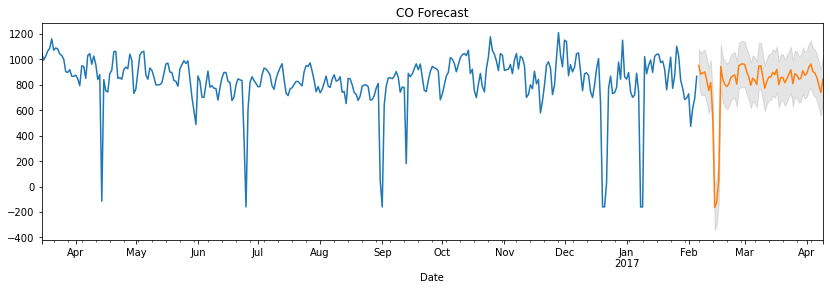

In [15]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=CO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = CO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("CO Forecast")
plt.show()

#### After fitting the data into the SARIMAX model, we can see that an AIC score of 3637.640. We then plot the train data against the predicted data, and we can see that the prediction fits very closely with the train data. 
##### ‎
#### We then obtain some metrics of the model, and we see that we have obtained a RMSE of 138, which is not bad.
##### ‎
#### Finally, we obtain an out-of-sample prediction of the next 63 days of values and plot the forecast plot. From the confidence intervals, we can see that although the true values may not be exactly the sme as the forecasted values, they will not go above or below the confidence intervals.
##  ‎

In [17]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=CO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('CO Forecast.csv', index=False)

### Auto ARIMA

In [95]:
arima_model = auto_arima(train_data['Value'], seasonal=True, m=52, exog=exogCO, n_jobs=-1)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  159
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -1040.242
Date:                            Thu, 04 Aug 2022   AIC                           2088.485
Time:                                    15:31:02   BIC                           2100.760
Sample:                                         0   HQIC                          2093.470
                                            - 159                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    457.3503     63.294      7.226      0.000     333.297     581.403
ar.L1          0.5005      0.053      9.411      0.000       0.396       0.605
ar.S.L52      -0.2329      0.094     -2.485      0.013      -0.417      -0.049
sigma2      2.764e+04   2281.470     12.114      0.000    2.32e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               185.40
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
pred_in_sample = arima_model.predict_in_sample()
pred_out_sample = arima_model.predict(n_periods=169)
pred_full = np.concatenate((pred_in_sample, pred_out_sample))

In [101]:
plot_train = train_data.drop(columns=['T', 'RH'])
plot_test = test_data.drop(columns=['T', 'RH'])

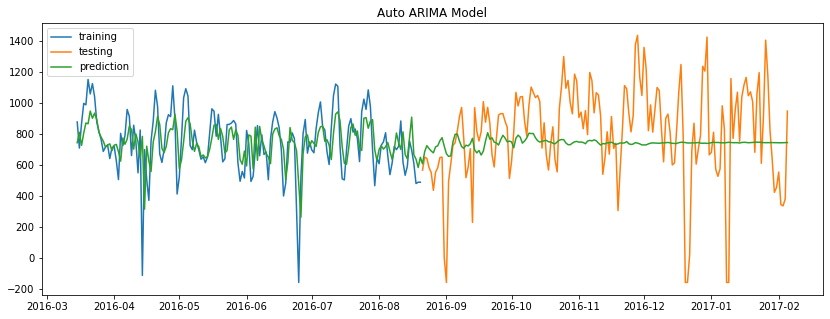

In [103]:
fig, ax = plt.subplots(figsize=(14, 5))
# ax.plot(train_data, label='training')
# ax.plot(test_data, label='testing')
ax.plot(plot_train, label = 'training')
ax.plot(plot_test, label = 'testing')
ax.plot(CO.index, pred_full, label='prediction')
plt.legend()
plt.title('Auto ARIMA Model')
plt.show()

In [33]:
## obtain csv of 63 AA values
pred_out_sample = arima_model.predict(n_periods=63)
AAforecastDF = pd.DataFrame(pred_out_sample, columns=['Value'])
AAforecastDF.to_csv('CO AA Forecast.csv', index=False)

## HC GAS

In [41]:
## extract HC gas only
HC = train_df.loc[train_df['Gas'] == "HC"]
HC = HC.drop(columns=['Gas'])
HC

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,729.800000
2016-03-16,9.833333,64.069791,681.441667
2016-03-17,11.292708,51.107292,806.583333
2016-03-18,12.866319,51.530903,794.258333
2016-03-19,16.016667,48.843750,755.083333
...,...,...,...
2017-02-01,5.267708,39.614930,562.650000
2017-02-02,5.267708,-24.010417,347.480556
2017-02-03,-14.272917,28.563542,414.475000


<AxesSubplot:xlabel='Value'>

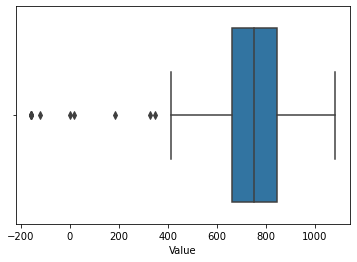

In [34]:
sns.boxplot(HC['Value'])

### Decomposition Plot

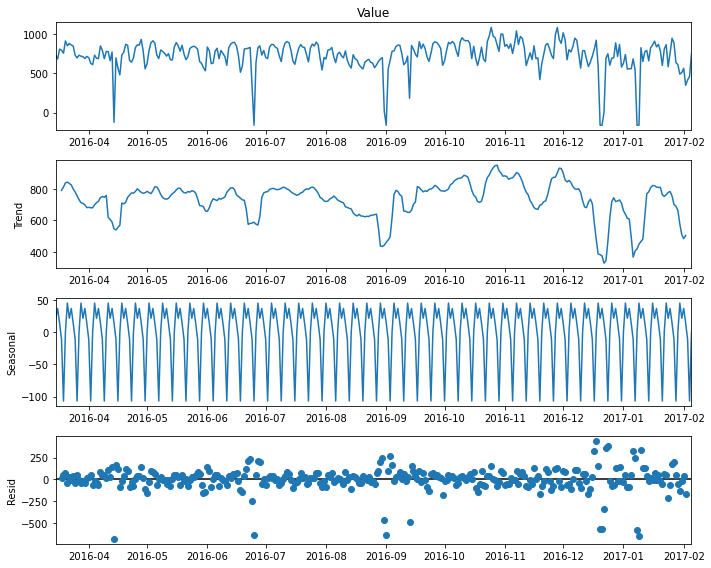

In [36]:
## HC gas decomposition plot
result = seasonal_decompose(HC['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

### Seasonal ACF and PACF Plots

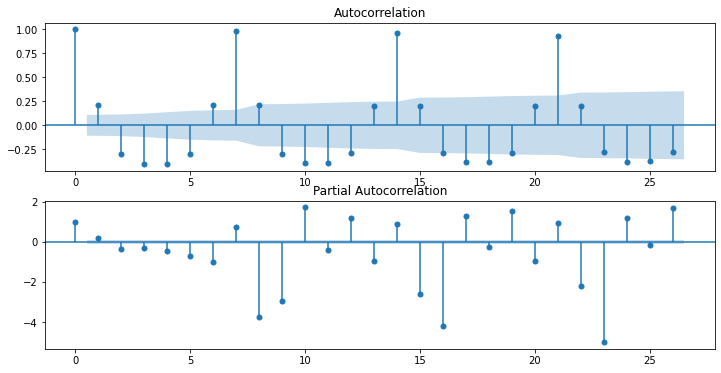

In [37]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

#### From the first decomposition plot, we can see that there is no trend, and there seems to be seasonality in the time series.
##### ‎
#### By plotting the seasonal ACF plot, we are able to tell that there is seasonality in the data, with a period of every 7 days
##  ‎

### Simple Moving Average Model

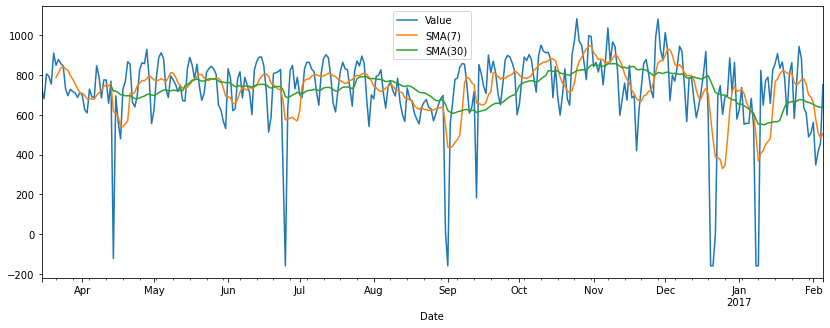

In [109]:
## Simple Moving Average Model
HC_SMA = HC['Value']
ax = HC_SMA.plot(figsize=(14, 5))
HC_SMA.rolling(window=7).mean().plot(ax=ax)
HC_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)'])
plt.show()

#### Similar to the previous Gas, the model does not fit well to the time series.

### Holt-Winters Exponential Smoothing Model

In [84]:
## split into train and test data
train_data = HC[HC.index<='2016-08-20']
test_data = HC[HC.index>'2016-08-20']
train_data = train_data.drop(columns=['T', 'RH'])
test_data = test_data.drop(columns=['T', 'RH'])

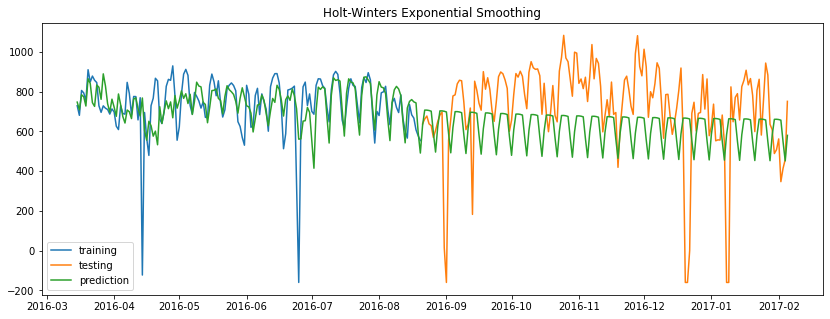

,MAE,MAPE,MSE,RMSE
0,81.635878,0.177102,18009.798689,134.200591


In [168]:
es_model = HWES(train_data, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
pred1 = es_model.predict(start='2016-03-15', end='2017-02-05')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

train_mae = mean_absolute_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mape = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mse = mean_squared_error(train_data, pred1[pred1.index<'2016-08-21'])
train_rmse = np.sqrt(train_mse)

# test_mae = mean_absolute_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mape = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mse = mean_squared_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_rmse = np.sqrt(test_mse)

metrics = []
metrics.append(train_mae)
metrics.append(train_mape)
metrics.append(train_mse)
metrics.append(train_rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

#### Similar to the previous Gas, the HWES model does not fit well to the time series, and produces a nonsensical repeating pattern.
##  ‎

In [38]:
## check for stationarity
HC1 = HC[HC.index<='2016-08-20']
HC2 = HC[HC.index>'2016-08-20']
HC1Mean = HC1['Value'].mean()
HC2Mean = HC2['Value'].mean()
HC1Var = HC1['Value'].var()
HC2Var = HC2['Value'].var()
print(f'Group 1 Mean: {HC1Mean} | Group 2 Mean: {HC2Mean}')
print(f'Group 1 Var: {HC1Var} | Group 2 Var: {HC2Var}')

Group 1 Mean: 735.9289133459121 | Group 2 Mean: 723.6241781651065
Group 1 Var: 20498.650280551938 | Group 2 Var: 51263.895697084175


In [39]:
## conduct augmented dicky fuller test
pval = adfuller(HC['Value'])
print('p-val of HC Gas: %f' % pval[1])

p-val of HC Gas: 0.000000


#### By checking the mean and standard deviation of the data, we can see that although the means of the 2 groups are very similar, the variances are significantly different.
##### ‎
#### Upon using the Augmented Dickey-Fuller test, we can see that it has a p-value of 0, and hence the time series is considered stationary
##  ‎

#### ACF and PACF Plots to obtain p,d,q values

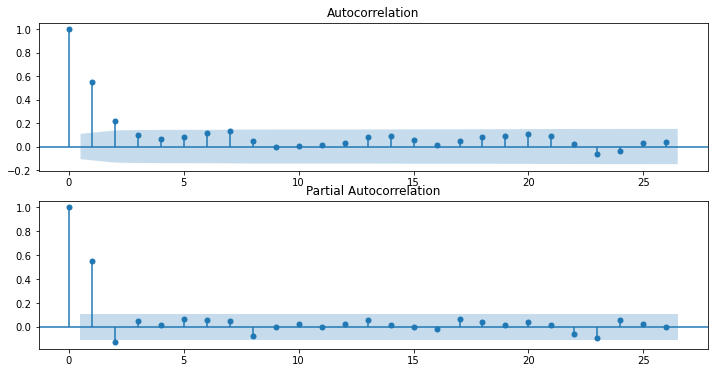

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(HC['Value'], ax=ax[0])
plot_pacf(HC['Value'], ax=ax[1])
plt.show()

#### From the PACF plot, p=1
#### From the ACF plot, q=1 or 2
#### Since the time series is stationary, no differencing is required and hence d=0
##  ‎

### SARIMAX

In [42]:
exogHC = HC[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(HC['Value'], order=(1,0,1),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogHC).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1902.283
Date:                           Fri, 12 Aug 2022   AIC                           3818.567
Time:                                   20:00:32   BIC                           3845.118
Sample:                               03-15-2016   HQIC                          3829.160
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.9859      0.639      1.542      0.123      -0.267       2.239
RH             3.6312      0.146     24.871      0.000       3.345       3.917
ar.L1          0.6269      0.066      9.554      0.000       0.498       0.755
ma.L1          0.0807      0.079      1.024      0.306      -0.074       0.235
ar.S.L7        0.9997      0.000   2958.140      0.000       0.999       1.000
ma.S.L7       -0.9338      0.029    -31.989      0.000      -0.991      -0.877
sigma2      5841.5375    441.040     13.245      0.000    4977.115    6705.960
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.24
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               1.53   Skew:                            -0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(HC['Value'], pred)
mape = mean_absolute_percentage_error(HC['Value'], pred)
mse = mean_squared_error(HC['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,64.246808,0.522457,7443.314501,86.274646


### SARIMAX GridSearch

In [19]:
## split into train and test data
train_data = HC[HC.index<='2016-08-20']
test_data = HC[HC.index>'2016-08-20']

In [42]:
## define params
orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
          (2,0,1),(2,0,2),(2,1,1),(2,1,2),
          (3,0,1),(3,0,2),(3,1,1),(3,1,2),
          (4,0,1),(4,0,2),(4,1,1),(4,1,2),
          (5,0,1),(5,0,2),(5,1,1),(5,1,2)]

seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
          (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
          (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
          (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
          (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7)]

trainExog = train_data[['T','RH']]
predExog = test_data[['T','RH']]

In [43]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order),str(seasonal_order))
        try:
            arima_model = SARIMAX(train_data['Value'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n', exog=trainExog).fit()
        
            pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("LU decomposition error.")

trying (1, 0, 1) (1, 0, 1, 7)
trying (1, 0, 1) (1, 0, 2, 7)
trying (1, 0, 1) (1, 1, 1, 7)
trying (1, 0, 1) (1, 1, 2, 7)
trying (1, 0, 1) (2, 0, 1, 7)
trying (1, 0, 1) (2, 0, 2, 7)
trying (1, 0, 1) (2, 1, 1, 7)
trying (1, 0, 1) (2, 1, 2, 7)
trying (1, 0, 1) (3, 0, 1, 7)
trying (1, 0, 1) (3, 0, 2, 7)
LU decomposition error.
trying (1, 0, 1) (3, 1, 1, 7)
trying (1, 0, 1) (3, 1, 2, 7)
trying (1, 0, 1) (4, 0, 1, 7)
trying (1, 0, 1) (4, 0, 2, 7)
trying (1, 0, 1) (4, 1, 1, 7)
trying (1, 0, 1) (4, 1, 2, 7)
trying (1, 0, 1) (5, 0, 1, 7)
LU decomposition error.
trying (1, 0, 1) (5, 0, 2, 7)
trying (1, 0, 1) (5, 1, 1, 7)
trying (1, 0, 1) (5, 1, 2, 7)
trying (1, 0, 2) (1, 0, 1, 7)
trying (1, 0, 2) (1, 0, 2, 7)
trying (1, 0, 2) (1, 1, 1, 7)
trying (1, 0, 2) (1, 1, 2, 7)
trying (1, 0, 2) (2, 0, 1, 7)
trying (1, 0, 2) (2, 0, 2, 7)
trying (1, 0, 2) (2, 1, 1, 7)
trying (1, 0, 2) (2, 1, 2, 7)
trying (1, 0, 2) (3, 0, 1, 7)
trying (1, 0, 2) (3, 0, 2, 7)
trying (1, 0, 2) (3, 1, 1, 7)
trying (1, 0, 2) (3, 1

trying (4, 0, 1) (4, 1, 1, 7)
trying (4, 0, 1) (4, 1, 2, 7)
trying (4, 0, 1) (5, 0, 1, 7)
trying (4, 0, 1) (5, 0, 2, 7)
LU decomposition error.
trying (4, 0, 1) (5, 1, 1, 7)
trying (4, 0, 1) (5, 1, 2, 7)
trying (4, 0, 2) (1, 0, 1, 7)
trying (4, 0, 2) (1, 0, 2, 7)
trying (4, 0, 2) (1, 1, 1, 7)
trying (4, 0, 2) (1, 1, 2, 7)
trying (4, 0, 2) (2, 0, 1, 7)
trying (4, 0, 2) (2, 0, 2, 7)
trying (4, 0, 2) (2, 1, 1, 7)
trying (4, 0, 2) (2, 1, 2, 7)
trying (4, 0, 2) (3, 0, 1, 7)
trying (4, 0, 2) (3, 0, 2, 7)
trying (4, 0, 2) (3, 1, 1, 7)
trying (4, 0, 2) (3, 1, 2, 7)
trying (4, 0, 2) (4, 0, 1, 7)
LU decomposition error.
trying (4, 0, 2) (4, 0, 2, 7)
trying (4, 0, 2) (4, 1, 1, 7)
trying (4, 0, 2) (4, 1, 2, 7)
trying (4, 0, 2) (5, 0, 1, 7)
trying (4, 0, 2) (5, 0, 2, 7)
trying (4, 0, 2) (5, 1, 1, 7)
trying (4, 0, 2) (5, 1, 2, 7)
trying (4, 1, 1) (1, 0, 1, 7)
trying (4, 1, 1) (1, 0, 2, 7)
trying (4, 1, 1) (1, 1, 1, 7)
trying (4, 1, 1) (1, 1, 2, 7)
trying (4, 1, 1) (2, 0, 1, 7)
trying (4, 1, 1) (2, 0

In [44]:
HC_metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
HC_metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
HC_metrics_df_rmse = metrics_df.sort_values('RMSE_test')
HC_metrics_df_aic = metrics_df.sort_values('AIC')

In [45]:
HC_metrics_df_rmse

,model,RMSE_train,RMSE_test,AIC
96,"(2, 0, 2),(2, 0, 1, 7)",107.18,122.67,2001.389603
251,"(4, 0, 2),(5, 1, 1, 7)",158.51,130.97,1683.510065
46,"(1, 1, 1),(3, 0, 2, 7)",82.31,132.61,1763.192968
111,"(2, 1, 1),(2, 0, 1, 7)",82.11,132.64,1761.148712
38,"(1, 1, 1),(1, 0, 2, 7)",82.27,132.94,1759.491229
...,...,...,...,...
234,"(4, 0, 2),(1, 0, 1, 7)",1086.12,1415.39,22.000000
147,"(3, 0, 1),(1, 0, 2, 7)",1302.28,1631.35,20.000000
312,"(5, 0, 2),(2, 0, 2, 7)",4161.94,6864.34,28.000000
11,"(1, 0, 1),(4, 0, 1, 7)",103251.01,288789.06,357.374243


In [46]:
HC_metrics_df_aic

,model,RMSE_train,RMSE_test,AIC
80,"(2, 0, 1),(2, 0, 1, 7)",645.54,764.59,18.000000
147,"(3, 0, 1),(1, 0, 2, 7)",1302.28,1631.35,20.000000
216,"(4, 0, 1),(1, 0, 1, 7)",823.12,902.59,20.000000
97,"(2, 0, 2),(2, 0, 2, 7)",664.25,1019.83,22.000000
234,"(4, 0, 2),(1, 0, 1, 7)",1086.12,1415.39,22.000000
...,...,...,...,...
309,"(5, 0, 2),(1, 0, 1, 7)",120.17,171.10,2044.077553
23,"(1, 0, 2),(2, 0, 2, 7)",108.07,263.34,2050.316398
93,"(2, 0, 2),(1, 0, 2, 7)",122.96,458.17,2053.548456
243,"(4, 0, 2),(3, 0, 2, 7)",92.93,183.68,2090.132114


#### Following the same method as before, we are able to identify the best order and seasonal_order for the SARIMAX model.
##  ‎

### SARIMAX - Ideal Parameters

In [20]:
exogHC = HC[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(HC['Value'], order=(2,0,2),
                      seasonal_order=(2, 0, 1, 7), trend='n',exog=exogHC).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -1976.508
Date:                             Fri, 12 Aug 2022   AIC                           3973.015
Time:                                     18:51:48   BIC                           4010.945
Sample:                                 03-15-2016   HQIC                          3988.148
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              2.4349      0.441      5.518      0.000       1.570       3.300
RH             3.5423      0.175     20.262      0.000       3.200       3.885
ar.L1          0.0582      0.021      2.770      0.006       0.017       0.099
ar.L2          0.9418      0.021     44.753      0.000       0.901       0.983
ma.L1          0.0012      0.179      0.007      0.994      -0.351       0.353
ma.L2         -0.9987      0.128     -7.817      0.000      -1.249      -0.748
ar.S.L7        1.0375      0.064     16.105      0.000       0.911       1.164
ar.S.L14      -0.0377      0.062     -0.609      0.542      -0.159       0.084
ma.S.L7       -0.9899      0.135     -7.323      0.000      -1.255      -0.725
sigma2      9467.2922   4.56e-05   2.07e+08      0.000    9467.292    9467.292
===================================================================================
Ljung-Box (L1) (Q):                 101.96   Jarque-Bera (JB):                 5.03
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               1.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+23. Standard errors may be unstable.
"""

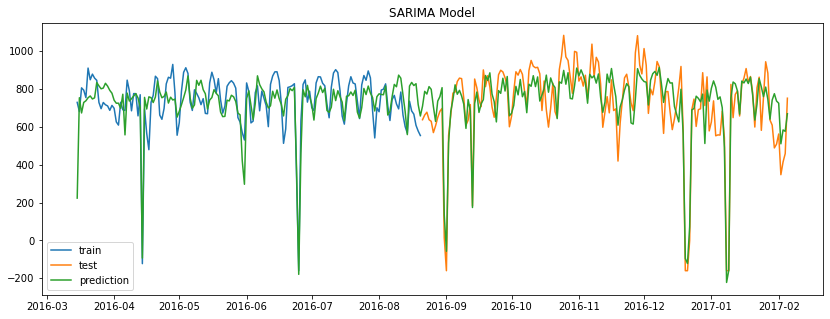

In [21]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data['Value'], label='train')
ax.plot(test_data['Value'], label='test')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [128]:
mae = mean_absolute_error(HC['Value'], pred)
mape = mean_absolute_percentage_error(HC['Value'], pred)
mse = mean_squared_error(HC['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,82.240204,1.470274,10566.540087,102.793677


In [22]:
## define HC test set
HC_test = test_df.loc[test_df['Gas'] == "HC"]
HC_test = HC_test.drop(columns=['Gas'])

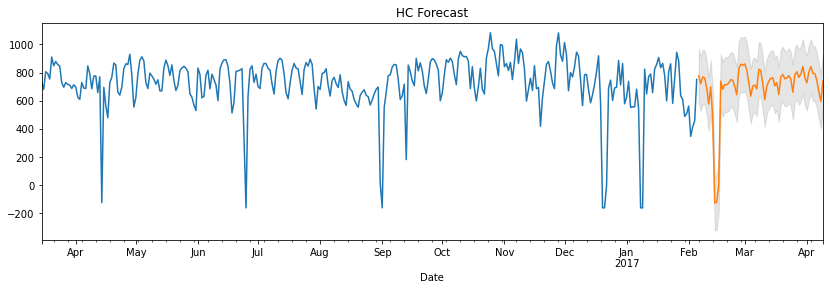

In [23]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=HC_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = HC['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("HC Forecast")
plt.show()

In [24]:
# obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=HC_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('HC Forecast.csv', index=False)

#### After fitting the data into the SARIMAX model, we can see that an AIC score of 3898.738. We then plot the train data against the predicted data, and we can see that the prediction fits very closely with the train data. 
##### ‎
#### We then obtain some metrics of the model, and we see that we have obtained a RMSE of 96, which is quite good.
##### ‎
#### Finally, we obtain an out-of-sample prediction of the next 63 days of values and plot the forecast plot. From the confidence intervals, we can see that although the true values may not be exactly the sme as the forecasted values, they will not go above or below the confidence intervals.
##  ‎

### Auto Arima

In [115]:
arima_model = auto_arima(train_data['Value'], seasonal=True, m=52, exog=exogHC, n_jobs=-1)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  159
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood               -1000.011
Date:                            Thu, 04 Aug 2022   AIC                           2008.021
Time:                                    20:48:21   BIC                           2020.297
Sample:                                         0   HQIC                          2013.006
                                            - 159                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    735.3295     18.970     38.763      0.000     698.150     772.509
ma.L1          0.3799      0.037     10.201      0.000       0.307       0.453
ma.S.L52      -0.1508      0.107     -1.406      0.160      -0.361       0.059
sigma2      1.685e+04   1044.365     16.139      0.000    1.48e+04    1.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              2136.95
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -3.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
plot_train = train_data.drop(columns=['T', 'RH'])
plot_test = test_data.drop(columns=['T', 'RH'])

In [117]:
pred_in_sample = arima_model.predict_in_sample()
pred_out_sample = arima_model.predict(n_periods=169)
pred_full = np.concatenate((pred_in_sample, pred_out_sample))

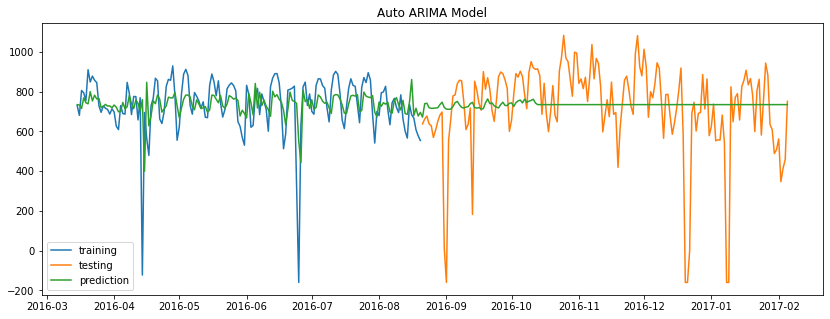

In [118]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(plot_train, label='training')
ax.plot(plot_test, label='testing')
ax.plot(HC.index, pred_full, label='prediction')
plt.legend()
plt.title('Auto ARIMA Model')
plt.show()

In [54]:
## obtain csv of 63 AA values
pred_out_sample = arima_model.predict(n_periods=63)
AAforecastDF = pd.DataFrame(pred_out_sample, columns=['Value'])
AAforecastDF.to_csv('HC AA Forecast.csv', index=False)

^^ less fitting might be due to outliers in 'HC'

## NO2 Gas

In [44]:
## extract NO2 gas only
NO = train_df.loc[train_df['Gas'] == "NO2"]
NO = NO.drop(columns=['Gas'])
NO

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,933.800000
2016-03-16,9.833333,64.069791,1021.750000
2016-03-17,11.292708,51.107292,881.375000
2016-03-18,12.866319,51.530903,794.527778
2016-03-19,16.016667,48.843750,800.883333
...,...,...,...
2017-02-01,5.267708,39.614930,797.647222
2017-02-02,5.267708,-24.010417,508.180556
2017-02-03,-14.272917,28.563542,819.733333


<AxesSubplot:xlabel='Value'>

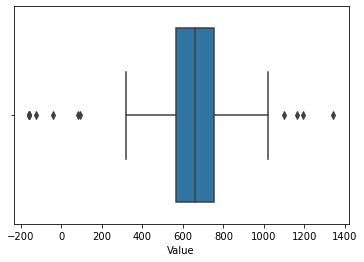

In [55]:
sns.boxplot(NO['Value'])

### Decomposition Plot

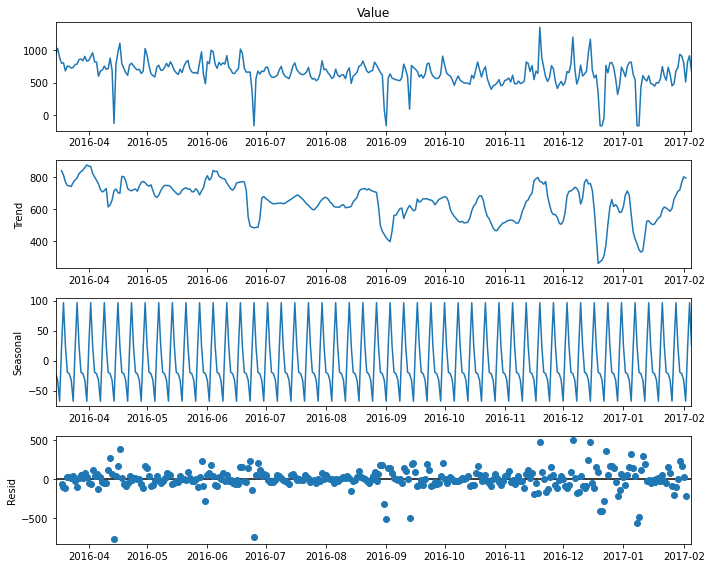

In [57]:
## NO2 gas decomposition plot
result = seasonal_decompose(NO['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

### Seasonal ACF and PACF Plots

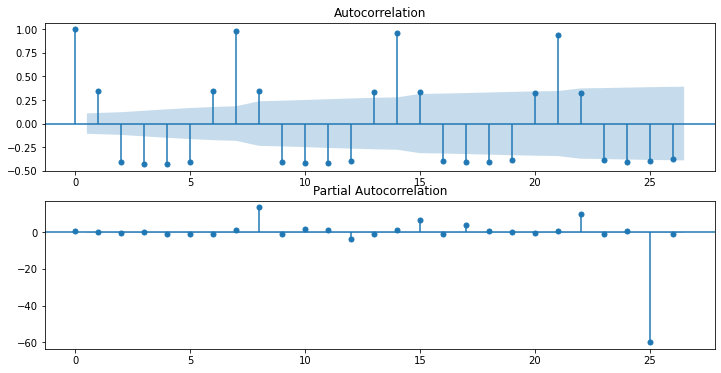

In [58]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

#### From the first decomposition plot, we can see that there is no trend, and there seems to be seasonality in the time series.
##### ‎
#### By plotting the seasonal ACF plot, we are able to tell that there is seasonality in the data, with a period of every 7 days
##  ‎

### Simple Moving Average Model

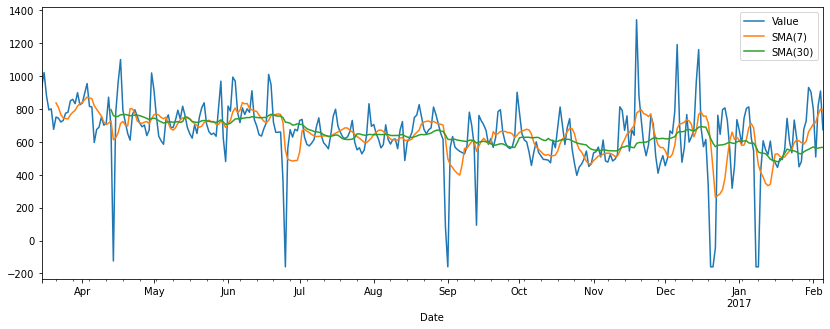

In [56]:
## Simple Moving Average Model
NO_SMA = NO['Value']
ax = NO_SMA.plot(figsize=(14, 5))
NO_SMA.rolling(window=7).mean().plot(ax=ax)
NO_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)', 'SMA(60)'])
plt.show()

#### Similar to the previous Gas, the model does not fit well to the time series.

### Holt-Winters Exponential Smoothing Model

In [170]:
## split into train and test data
train_data = NO[NO.index<='2016-08-20']
test_data = NO[NO.index>'2016-08-20']
train_data = train_data.drop(columns=['T', 'RH'])
test_data = test_data.drop(columns=['T', 'RH'])

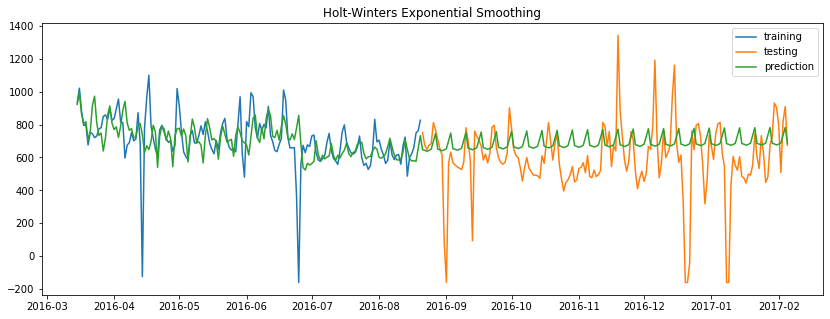

,MAE,MAPE,MSE,RMSE
0,91.382551,0.196108,23369.450656,152.870699


In [171]:
es_model = HWES(train_data, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
pred1 = es_model.predict(start='2016-03-15', end='2017-02-05')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

train_mae = mean_absolute_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mape = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mse = mean_squared_error(train_data, pred1[pred1.index<'2016-08-21'])
train_rmse = np.sqrt(train_mse)

# test_mae = mean_absolute_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mape = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mse = mean_squared_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_rmse = np.sqrt(test_mse)

metrics = []
metrics.append(train_mae)
metrics.append(train_mape)
metrics.append(train_mse)
metrics.append(train_rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

#### Similar to the previous Gas, the HWES model does nto fit well to the time series, and produces a nonsensical repeating pattern.

#### From the first decomposition plot, we can see that there is no trend, and there seems to be seasonality in the time series.
##### ‎
#### By plotting the seasonal ACF plot, we are able to tell that there is seasonality in the data, with a period of every 7 days
##  ‎

In [59]:
## check for stationarity
NO1 = NO[NO.index<='2016-08-20']
NO2 = NO[NO.index>'2016-08-20']
NO1Mean = NO1['Value'].mean()
NO2Mean = NO2['Value'].mean()
NO1Var = NO1['Value'].var()
NO2Var = NO2['Value'].var()
print(f'Group 1 Mean: {NO1Mean} | Group 2 Mean: {NO2Mean}')
print(f'Group 1 Var: {NO1Var} | Group 2 Var: {NO2Var}')

Group 1 Mean: 707.6746680654088 | Group 2 Mean: 595.908777123905
Group 1 Var: 23166.116227942657 | Group 2 Var: 45119.29175581713


In [60]:
## conduct augmented dicky fuller test
pval = adfuller(NO['Value'])
print('number of observations: ' + str(pval[3]))
print('p-val of NO2 Gas: %f' % pval[1])

number of observations: 326
p-val of NO2 Gas: 0.000000


#### By checking the mean and standard deviation of the data, we can see that although the means of the 2 groups are very similar, the variances are significantly different.
##### ‎
#### Upon using the Augmented Dickey-Fuller test, we can see that it has a p-value of 0, and hence the time series is considered stationary
##  ‎

#### ACF and PACF Plots to obtain p,d,q values

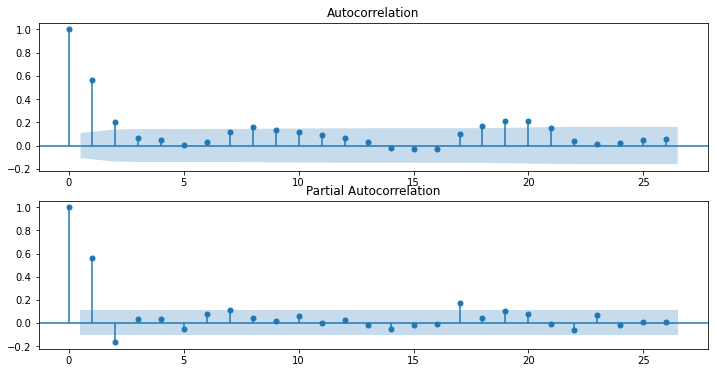

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(NO['Value'], ax=ax[0])
plot_pacf(NO['Value'], ax=ax[1])
plt.show()

#### From the PACF plot, p=1 or 2
#### From the ACF plot, q=1 or 2
#### Since the time series is stationary, no differencing is required and hence d=0
##  ‎

### SARIMAX

In [45]:
exogNO = NO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(NO['Value'], order=(1,0,1),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogNO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2013.033
Date:                           Fri, 12 Aug 2022   AIC                           4040.066
Time:                                   20:02:59   BIC                           4066.617
Sample:                               03-15-2016   HQIC                          4050.659
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.2739      1.039      0.264      0.792      -1.762       2.310
RH             3.0142      0.172     17.556      0.000       2.678       3.351
ar.L1          0.6225      0.063      9.895      0.000       0.499       0.746
ma.L1          0.1305      0.072      1.818      0.069      -0.010       0.271
ar.S.L7        0.9983      0.001    733.208      0.000       0.996       1.001
ma.S.L7       -0.9125      0.027    -33.784      0.000      -0.965      -0.860
sigma2      1.278e+04    712.945     17.930      0.000    1.14e+04    1.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               507.27
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.67   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(NO['Value'], pred)
mape = mean_absolute_percentage_error(NO['Value'], pred)
mse = mean_squared_error(NO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,79.839308,0.126179,13847.278529,117.67446


### SARIMAX GridSearch

In [26]:
## split into train and test data
train_data = NO[NO.index<='2016-08-20']
test_data = NO[NO.index>'2016-08-20']

In [63]:
## define params
orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
          (2,0,1),(2,0,2),(2,1,1),(2,1,2),
          (3,0,1),(3,0,2),(3,1,1),(3,1,2),
          (4,0,1),(4,0,2),(4,1,1),(4,1,2),
          (5,0,1),(5,0,2),(5,1,1),(5,1,2),
          (6,0,1),(6,0,2),(6,1,1),(6,1,2)]

seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
          (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
          (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
          (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
          (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7),
          (6,0,1,7),(6,0,2,7),(6,1,1,7),(6,1,2,7)]

trainExog = train_data[['T','RH']]
predExog = test_data[['T','RH']]

In [64]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order),str(seasonal_order))
        try:
            arima_model = SARIMAX(train_data['Value'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n', exog=trainExog).fit()
        
            pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("LU decomposition error.")

trying (1, 0, 1) (1, 0, 1, 7)
trying (1, 0, 1) (1, 0, 2, 7)
trying (1, 0, 1) (1, 1, 1, 7)
trying (1, 0, 1) (1, 1, 2, 7)
trying (1, 0, 1) (2, 0, 1, 7)
trying (1, 0, 1) (2, 0, 2, 7)
trying (1, 0, 1) (2, 1, 1, 7)
trying (1, 0, 1) (2, 1, 2, 7)
trying (1, 0, 1) (3, 0, 1, 7)
trying (1, 0, 1) (3, 0, 2, 7)
trying (1, 0, 1) (3, 1, 1, 7)
trying (1, 0, 1) (3, 1, 2, 7)
trying (1, 0, 1) (4, 0, 1, 7)
trying (1, 0, 1) (4, 0, 2, 7)
LU decomposition error.
trying (1, 0, 1) (4, 1, 1, 7)
trying (1, 0, 1) (4, 1, 2, 7)
trying (1, 0, 1) (5, 0, 1, 7)
trying (1, 0, 1) (5, 0, 2, 7)
trying (1, 0, 1) (5, 1, 1, 7)
trying (1, 0, 1) (5, 1, 2, 7)
trying (1, 0, 1) (6, 0, 1, 7)
trying (1, 0, 1) (6, 0, 2, 7)
trying (1, 0, 1) (6, 1, 1, 7)
trying (1, 0, 1) (6, 1, 2, 7)
trying (1, 0, 2) (1, 0, 1, 7)
trying (1, 0, 2) (1, 0, 2, 7)
trying (1, 0, 2) (1, 1, 1, 7)
trying (1, 0, 2) (1, 1, 2, 7)
trying (1, 0, 2) (2, 0, 1, 7)
trying (1, 0, 2) (2, 0, 2, 7)
trying (1, 0, 2) (2, 1, 1, 7)
trying (1, 0, 2) (2, 1, 2, 7)
trying (1, 0, 2)

trying (3, 1, 2) (1, 1, 1, 7)
trying (3, 1, 2) (1, 1, 2, 7)
trying (3, 1, 2) (2, 0, 1, 7)
trying (3, 1, 2) (2, 0, 2, 7)
trying (3, 1, 2) (2, 1, 1, 7)
trying (3, 1, 2) (2, 1, 2, 7)
trying (3, 1, 2) (3, 0, 1, 7)
trying (3, 1, 2) (3, 0, 2, 7)
trying (3, 1, 2) (3, 1, 1, 7)
trying (3, 1, 2) (3, 1, 2, 7)
trying (3, 1, 2) (4, 0, 1, 7)
trying (3, 1, 2) (4, 0, 2, 7)
trying (3, 1, 2) (4, 1, 1, 7)
trying (3, 1, 2) (4, 1, 2, 7)
trying (3, 1, 2) (5, 0, 1, 7)
trying (3, 1, 2) (5, 0, 2, 7)
trying (3, 1, 2) (5, 1, 1, 7)
trying (3, 1, 2) (5, 1, 2, 7)
trying (3, 1, 2) (6, 0, 1, 7)
trying (3, 1, 2) (6, 0, 2, 7)
trying (3, 1, 2) (6, 1, 1, 7)
trying (3, 1, 2) (6, 1, 2, 7)
trying (4, 0, 1) (1, 0, 1, 7)
trying (4, 0, 1) (1, 0, 2, 7)
trying (4, 0, 1) (1, 1, 1, 7)
trying (4, 0, 1) (1, 1, 2, 7)
trying (4, 0, 1) (2, 0, 1, 7)
trying (4, 0, 1) (2, 0, 2, 7)
trying (4, 0, 1) (2, 1, 1, 7)
trying (4, 0, 1) (2, 1, 2, 7)
trying (4, 0, 1) (3, 0, 1, 7)
trying (4, 0, 1) (3, 0, 2, 7)
LU decomposition error.
trying (4, 0, 1)

trying (6, 0, 2) (6, 0, 1, 7)
LU decomposition error.
trying (6, 0, 2) (6, 0, 2, 7)
trying (6, 0, 2) (6, 1, 1, 7)
trying (6, 0, 2) (6, 1, 2, 7)
trying (6, 1, 1) (1, 0, 1, 7)
trying (6, 1, 1) (1, 0, 2, 7)
trying (6, 1, 1) (1, 1, 1, 7)
trying (6, 1, 1) (1, 1, 2, 7)
trying (6, 1, 1) (2, 0, 1, 7)
trying (6, 1, 1) (2, 0, 2, 7)
trying (6, 1, 1) (2, 1, 1, 7)
trying (6, 1, 1) (2, 1, 2, 7)
trying (6, 1, 1) (3, 0, 1, 7)
trying (6, 1, 1) (3, 0, 2, 7)
trying (6, 1, 1) (3, 1, 1, 7)
trying (6, 1, 1) (3, 1, 2, 7)
trying (6, 1, 1) (4, 0, 1, 7)
trying (6, 1, 1) (4, 0, 2, 7)
trying (6, 1, 1) (4, 1, 1, 7)
trying (6, 1, 1) (4, 1, 2, 7)
trying (6, 1, 1) (5, 0, 1, 7)
trying (6, 1, 1) (5, 0, 2, 7)
trying (6, 1, 1) (5, 1, 1, 7)
trying (6, 1, 1) (5, 1, 2, 7)
trying (6, 1, 1) (6, 0, 1, 7)
trying (6, 1, 1) (6, 0, 2, 7)
trying (6, 1, 1) (6, 1, 1, 7)
trying (6, 1, 1) (6, 1, 2, 7)
trying (6, 1, 2) (1, 0, 1, 7)
trying (6, 1, 2) (1, 0, 2, 7)
trying (6, 1, 2) (1, 1, 1, 7)
trying (6, 1, 2) (1, 1, 2, 7)
trying (6, 1, 2)

In [65]:
NO2_metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
NO2_metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
NO2_metrics_df_rmse = metrics_df.sort_values('RMSE_test')
NO2_metrics_df_aic = metrics_df.sort_values('AIC')

In [66]:
NO2_metrics_df_rmse

,model,RMSE_train,RMSE_test,AIC
318,"(4, 0, 2),(6, 1, 1, 7)",170.09,153.53,1774.187346
499,"(6, 1, 1),(1, 0, 2, 7)",98.70,154.20,1832.738826
453,"(5, 1, 2),(6, 0, 2, 7)",97.66,154.41,1833.072978
476,"(6, 0, 1),(6, 1, 1, 7)",169.30,154.62,1774.706650
521,"(6, 1, 1),(6, 1, 2, 7)",108.12,154.70,1770.169150
...,...,...,...,...
461,"(6, 0, 1),(2, 0, 2, 7)",765.78,673.81,28.000000
122,"(2, 0, 2),(3, 0, 2, 7)",113.17,909.74,1925.484377
227,"(3, 0, 2),(6, 0, 1, 7)",105.18,957.80,1897.358588
468,"(6, 0, 1),(4, 0, 2, 7)",1534.75,2777.06,32.000000


In [67]:
NO2_metrics_df_aic

,model,RMSE_train,RMSE_test,AIC
461,"(6, 0, 1),(2, 0, 2, 7)",765.78,673.81,28.000000
468,"(6, 0, 1),(4, 0, 2, 7)",1534.75,2777.06,32.000000
118,"(2, 0, 2),(2, 0, 2, 7)",1787.24,3191.07,1070.190598
47,"(1, 1, 1),(1, 1, 1, 7)",107.19,213.25,1754.267781
139,"(2, 1, 1),(1, 1, 1, 7)",107.32,215.36,1754.756019
...,...,...,...,...
224,"(3, 0, 2),(5, 0, 2, 7)",110.69,524.20,2055.826949
316,"(4, 0, 2),(6, 0, 1, 7)",107.22,470.01,2056.653610
130,"(2, 0, 2),(5, 0, 2, 7)",105.70,317.67,2058.621999
317,"(4, 0, 2),(6, 0, 2, 7)",105.76,467.64,2060.425038


#### Following the same method as before, we are able to identify the best order and seasonal_order for the SARIMAX model.
##  ‎

### SARIMAX - Ideal Parameters

In [27]:
exogNO = NO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(NO['Value'], order=(4,0,2),
                      seasonal_order=(6, 1, 1, 7), trend='n',exog=exogNO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(4, 0, 2)x(6, 1, [1], 7)   Log Likelihood               -1957.597
Date:                             Fri, 12 Aug 2022   AIC                           3947.193
Time:                                     18:52:26   BIC                           4007.536
Sample:                                 03-15-2016   HQIC                          3971.287
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -1.1277      0.961     -1.174      0.241      -3.011       0.756
RH             3.0655      0.173     17.768      0.000       2.727       3.404
ar.L1          0.7067      0.093      7.631      0.000       0.525       0.888
ar.L2          0.8525      0.145      5.888      0.000       0.569       1.136
ar.L3         -0.6979      0.084     -8.263      0.000      -0.863      -0.532
ar.L4          0.1386      0.058      2.379      0.017       0.024       0.253
ma.L1          0.0041      0.138      0.030      0.976      -0.267       0.275
ma.L2         -0.9930      0.126     -7.870      0.000      -1.240      -0.746
ar.S.L7       -0.0171      0.056     -0.304      0.761      -0.127       0.093
ar.S.L14      -0.0163      0.086     -0.189      0.850      -0.186       0.153
ar.S.L21       0.1061      0.080      1.325      0.185      -0.051       0.263
ar.S.L28       0.0250      0.069      0.364      0.716      -0.110       0.160
ar.S.L35      -0.0995      0.072     -1.380      0.168      -0.241       0.042
ar.S.L42      -0.0419      0.071     -0.593      0.554      -0.181       0.097
ma.S.L7       -0.9580      0.056    -17.090      0.000      -1.068      -0.848
sigma2      1.095e+04    991.637     11.046      0.000    9010.098    1.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               801.38
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.61e+14. Standard errors may be unstable.
"""

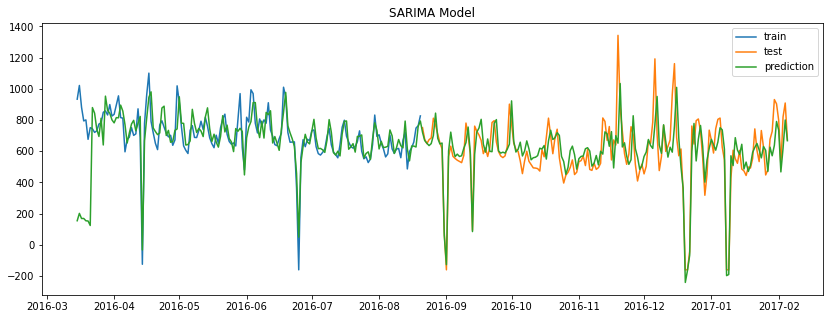

In [28]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
# ax.plot(NO['Value'])
ax.plot(train_data['Value'], label='train')
ax.plot(test_data['Value'], label='test')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [29]:
mae = mean_absolute_error(NO['Value'], pred)
mape = mean_absolute_percentage_error(NO['Value'], pred)
mse = mean_squared_error(NO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,88.981597,0.136727,21103.331886,145.269859


In [30]:
## define NO test set
NO_test = test_df.loc[test_df['Gas'] == "NO2"]
NO_test = NO_test.drop(columns=['Gas'])

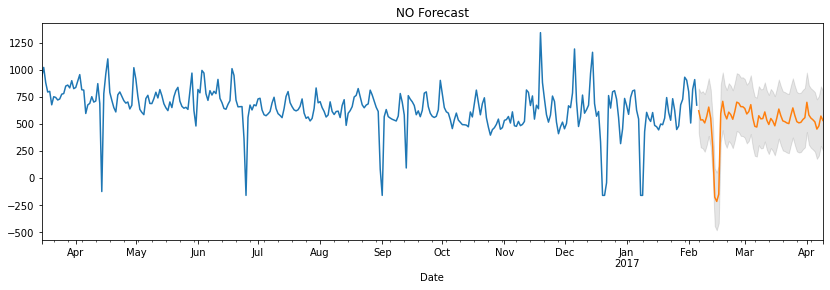

In [31]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=NO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = NO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("NO Forecast")
plt.show()

#### After fitting the data into the SARIMAX model, we can see that an AIC score of 3913.548. We then plot the train data against the predicted data, and we can see that the prediction fits very closely with the train data. 
##### ‎
#### We then obtain some metrics of the model, and we see that we have obtained a RMSE of 191, which is decent.
##### ‎
#### Finally, we obtain an out-of-sample prediction of the next 63 days of values and plot the forecast plot. From the confidence intervals, we can see that although the true values may not be exactly the sme as the forecasted values, they will not go above or below the confidence intervals.
##  ‎

In [32]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=NO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('NO2 Forecast.csv', index=False)

### Auto Arima

In [129]:
arima_model = auto_arima(train_data['Value'], seasonal=True, m=52, exog=exogNO, n_jobs=-1)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -996.991
Date:                Thu, 04 Aug 2022   AIC                           2001.982
Time:                        21:07:51   BIC                           2014.233
Sample:                             0   HQIC                          2006.957
                                - 159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4589      0.059      7.763      0.000       0.343       0.575
ar.L2         -0.2050      0.101     -2.027      0.043      -0.403      -0.007
ma.L1         -0.9493      0.046    -20.566      0.000      -1.040      -0.859
sigma2      1.752e+04    734.474     23.854      0.000    1.61e+04     1.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              1543.31
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -2.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
plot_train = train_data.drop(columns=['T', 'RH'])
plot_test = test_data.drop(columns=['T', 'RH'])

In [131]:
pred_in_sample = arima_model.predict_in_sample()
pred_out_sample = arima_model.predict(n_periods=169)
pred_full = np.concatenate((pred_in_sample, pred_out_sample))

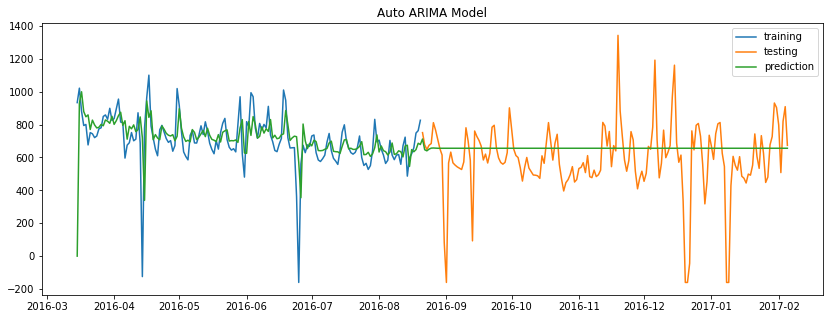

In [132]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(plot_train, label='training')
ax.plot(plot_test, label='testing')
ax.plot(NO.index, pred_full, label='prediction')
plt.legend()
plt.title('Auto ARIMA Model')
plt.show()

In [75]:
## obtain csv of 63 AA values
pred_out_sample = arima_model.predict(n_periods=63)
AAforecastDF = pd.DataFrame(pred_out_sample, columns=['Value'])
AAforecastDF.to_csv('NO3 AA Forecast.csv', index=False)

## O3 Gas

In [50]:
## extract O3 gas only
O = train_df.loc[train_df['Gas'] == "O3"]
O = O.drop(columns=['Gas'])
O

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,876.833333
2016-03-16,9.833333,64.069791,708.025000
2016-03-17,11.292708,51.107292,867.375000
2016-03-18,12.866319,51.530903,996.625000
2016-03-19,16.016667,48.843750,987.341667
...,...,...,...
2017-02-01,5.267708,39.614930,553.180556
2017-02-02,5.267708,-24.010417,343.500000
2017-02-03,-14.272917,28.563542,334.458333


### Decomposition Plot

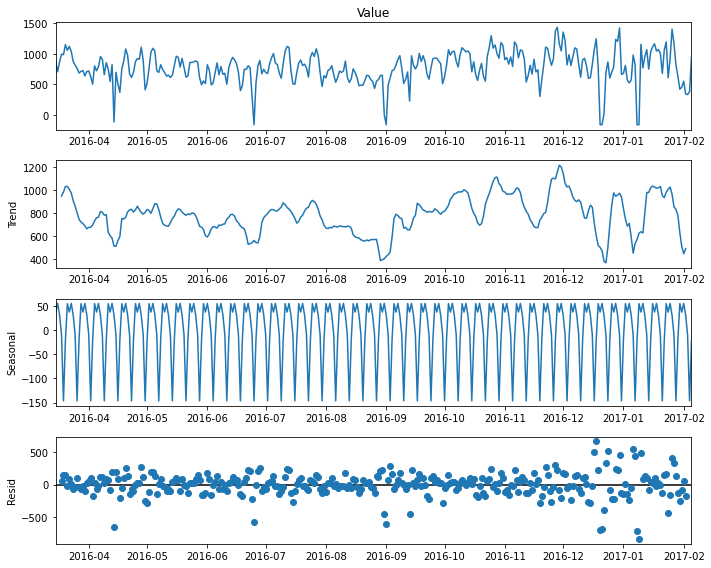

In [77]:
## O3 gas decomposition plot
result = seasonal_decompose(O['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

### Seasonal ACF and PACF Plots

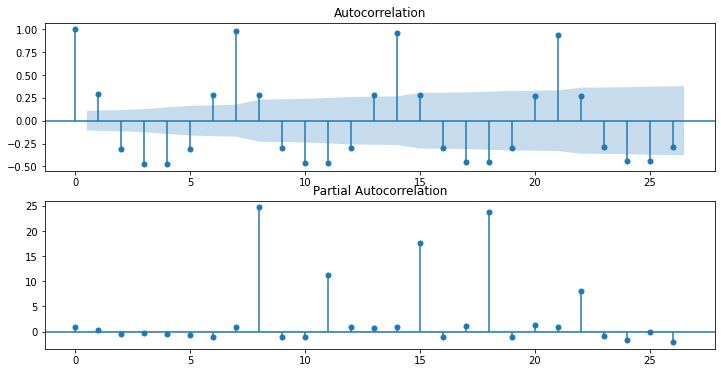

In [78]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

#### From the first decomposition plot, we can see that there is no trend, and there seems to be seasonality in the time series.
##### ‎
#### By plotting the seasonal ACF plot, we are able to tell that there is seasonality in the data, with a period of every 7 days
##  ‎

### Simple Moving Average Model

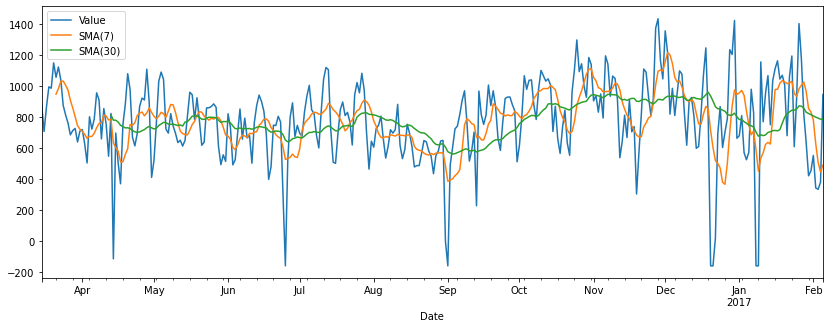

In [76]:
## Simple Moving Average Model
O_SMA = O['Value']
ax = O_SMA.plot(figsize=(14, 5))
O_SMA.rolling(window=7).mean().plot(ax=ax)
O_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)', 'SMA(60)'])
plt.show()

#### Similar to the previous Gas, the model does not fit well to the time series.

### Holt-Winters Exponential Smoothing Model

In [174]:
## split into train and test data
train_data = O[O.index<='2016-08-20']
test_data = O[O.index>'2016-08-20']
train_data = train_data.drop(columns=['T', 'RH'])
test_data = test_data.drop(columns=['T', 'RH'])

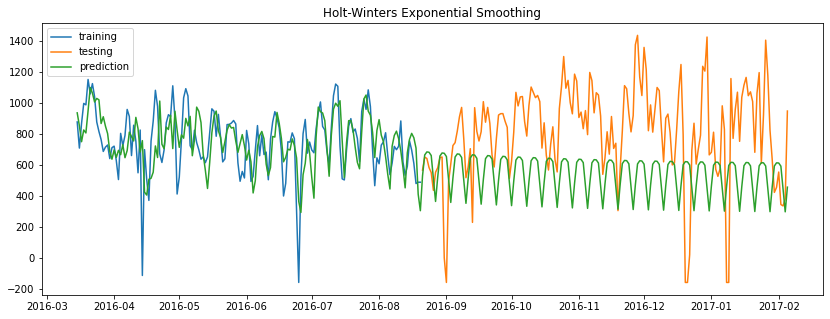

,MAE,MAPE,MSE,RMSE
0,133.725583,0.250424,30628.54009,175.010114


In [175]:
es_model = HWES(train_data, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
pred1 = es_model.predict(start='2016-03-15', end='2017-02-05')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

train_mae = mean_absolute_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mape = mean_absolute_percentage_error(train_data, pred1[pred1.index<'2016-08-21'])
train_mse = mean_squared_error(train_data, pred1[pred1.index<'2016-08-21'])
train_rmse = np.sqrt(train_mse)

# test_mae = mean_absolute_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mape = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mse = mean_squared_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_rmse = np.sqrt(test_mse)

metrics = []
metrics.append(train_mae)
metrics.append(train_mape)
metrics.append(train_mse)
metrics.append(train_rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

#### Similar to the previous Gas, the HWES model does not fit well to the time series, and produces a nonsensical repeating pattern.
##  ‎

In [79]:
## check for stationarity
O1 = O[O.index<='2016-08-20']
O2 = O[O.index>'2016-08-20']
O1Mean = O1['Value'].mean()
O2Mean = O2['Value'].mean()
O1Var = O1['Value'].var()
O2Var = O2['Value'].var()
print(f'Group 1 Mean: {O1Mean} | Group 2 Mean: {O2Mean}')
print(f'Group 1 Var: {O1Var} | Group 2 Var: {O2Var}')

Group 1 Mean: 746.6952655578614 | Group 2 Mean: 812.5275148096445
Group 1 Var: 40194.815536187154 | Group 2 Var: 93537.97818321272


In [80]:
## conduct augmented dicky fuller test
pval = adfuller(O['Value'])
print('p-val of O3 Gas: %f' % pval[1])

p-val of O3 Gas: 0.000000


#### By checking the mean and standard deviation of the data, we can see that although the means of the 2 groups are very similar, the variances are significantly different.
##### ‎
#### Upon using the Augmented Dickey-Fuller test, we can see that it has a p-value of 0, and hence the time series is considered stationary
##  ‎

#### ACF and PACF Plots too obtain p,d,q values

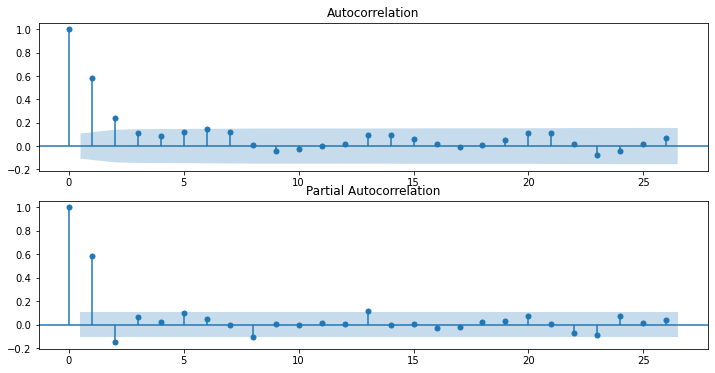

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(O['Value'], ax=ax[0])
plot_pacf(O['Value'], ax=ax[1])
plt.show()

#### From the PACF plot, p=1 or 2
#### From the ACF plot, q=1 or 2
#### Since the time series is stationary, no differencing is required and hence d=0
##  ‎

### SARIMAX

In [51]:
exogO = O[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(O['Value'], order=(1,0,1),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2103.440
Date:                           Fri, 12 Aug 2022   AIC                           4220.880
Time:                                   20:23:50   BIC                           4247.431
Sample:                               03-15-2016   HQIC                          4231.473
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.7891      0.931      0.847      0.397      -1.036       2.614
RH             4.0509      0.230     17.577      0.000       3.599       4.503
ar.L1          0.5285      0.065      8.186      0.000       0.402       0.655
ma.L1          0.2316      0.072      3.203      0.001       0.090       0.373
ar.S.L7        0.9991      0.001    998.551      0.000       0.997       1.001
ma.S.L7       -0.9292      0.029    -31.572      0.000      -0.987      -0.871
sigma2      2.034e+04   1529.849     13.294      0.000    1.73e+04    2.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.62
Prob(Q):                              0.85   Prob(JB):                         0.10
Heteroskedasticity (H):               2.01   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(O['Value'], pred)
mape = mean_absolute_percentage_error(O['Value'], pred)
mse = mean_squared_error(O['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,116.550471,0.291811,23256.224971,152.499918


### SARIMAX GridSearch

In [53]:
## split into train and test data
train_data = O[O.index<='2016-08-20']
test_data = O[O.index>'2016-08-20']

In [83]:
## define params
orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
          (2,0,1),(2,0,2),(2,1,1),(2,1,2),
          (3,0,1),(3,0,2),(3,1,1),(3,1,2),
          (4,0,1),(4,0,2),(4,1,1),(4,1,2),
          (5,0,1),(5,0,2),(5,1,1),(5,1,2),
          (6,0,1),(6,0,2),(6,1,1),(6,1,2)]

seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
          (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
          (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
          (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
          (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7),
          (6,0,1,7),(6,0,2,7),(6,1,1,7),(6,1,2,7)]

trainExog = train_data[['T','RH']]
predExog = test_data[['T','RH']]

In [84]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order),str(seasonal_order))
        try:
            arima_model = SARIMAX(train_data['Value'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n', exog=trainExog).fit()
        
            pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("LU decomposition error.")

trying (1, 0, 1) (1, 0, 1, 7)
trying (1, 0, 1) (1, 0, 2, 7)
trying (1, 0, 1) (1, 1, 1, 7)
trying (1, 0, 1) (1, 1, 2, 7)
trying (1, 0, 1) (2, 0, 1, 7)
trying (1, 0, 1) (2, 0, 2, 7)
trying (1, 0, 1) (2, 1, 1, 7)
trying (1, 0, 1) (2, 1, 2, 7)
trying (1, 0, 1) (3, 0, 1, 7)
trying (1, 0, 1) (3, 0, 2, 7)
trying (1, 0, 1) (3, 1, 1, 7)
trying (1, 0, 1) (3, 1, 2, 7)
trying (1, 0, 1) (4, 0, 1, 7)
trying (1, 0, 1) (4, 0, 2, 7)
trying (1, 0, 1) (4, 1, 1, 7)
trying (1, 0, 1) (4, 1, 2, 7)
trying (1, 0, 1) (5, 0, 1, 7)
trying (1, 0, 1) (5, 0, 2, 7)
trying (1, 0, 1) (5, 1, 1, 7)
trying (1, 0, 1) (5, 1, 2, 7)
trying (1, 0, 1) (6, 0, 1, 7)
trying (1, 0, 1) (6, 0, 2, 7)
trying (1, 0, 1) (6, 1, 1, 7)
trying (1, 0, 1) (6, 1, 2, 7)
trying (1, 0, 2) (1, 0, 1, 7)
trying (1, 0, 2) (1, 0, 2, 7)
trying (1, 0, 2) (1, 1, 1, 7)
trying (1, 0, 2) (1, 1, 2, 7)
trying (1, 0, 2) (2, 0, 1, 7)
trying (1, 0, 2) (2, 0, 2, 7)
trying (1, 0, 2) (2, 1, 1, 7)
trying (1, 0, 2) (2, 1, 2, 7)
trying (1, 0, 2) (3, 0, 1, 7)
trying (1,

trying (3, 1, 2) (1, 1, 1, 7)
trying (3, 1, 2) (1, 1, 2, 7)
trying (3, 1, 2) (2, 0, 1, 7)
trying (3, 1, 2) (2, 0, 2, 7)
trying (3, 1, 2) (2, 1, 1, 7)
trying (3, 1, 2) (2, 1, 2, 7)
trying (3, 1, 2) (3, 0, 1, 7)
trying (3, 1, 2) (3, 0, 2, 7)
trying (3, 1, 2) (3, 1, 1, 7)
trying (3, 1, 2) (3, 1, 2, 7)
trying (3, 1, 2) (4, 0, 1, 7)
trying (3, 1, 2) (4, 0, 2, 7)
trying (3, 1, 2) (4, 1, 1, 7)
trying (3, 1, 2) (4, 1, 2, 7)
trying (3, 1, 2) (5, 0, 1, 7)
trying (3, 1, 2) (5, 0, 2, 7)
trying (3, 1, 2) (5, 1, 1, 7)
trying (3, 1, 2) (5, 1, 2, 7)
trying (3, 1, 2) (6, 0, 1, 7)
trying (3, 1, 2) (6, 0, 2, 7)
trying (3, 1, 2) (6, 1, 1, 7)
trying (3, 1, 2) (6, 1, 2, 7)
trying (4, 0, 1) (1, 0, 1, 7)
trying (4, 0, 1) (1, 0, 2, 7)
trying (4, 0, 1) (1, 1, 1, 7)
trying (4, 0, 1) (1, 1, 2, 7)
trying (4, 0, 1) (2, 0, 1, 7)
trying (4, 0, 1) (2, 0, 2, 7)
LU decomposition error.
trying (4, 0, 1) (2, 1, 1, 7)
trying (4, 0, 1) (2, 1, 2, 7)
trying (4, 0, 1) (3, 0, 1, 7)
trying (4, 0, 1) (3, 0, 2, 7)
trying (4, 0, 1)

trying (6, 0, 2) (6, 0, 2, 7)
trying (6, 0, 2) (6, 1, 1, 7)
trying (6, 0, 2) (6, 1, 2, 7)
trying (6, 1, 1) (1, 0, 1, 7)
trying (6, 1, 1) (1, 0, 2, 7)
trying (6, 1, 1) (1, 1, 1, 7)
trying (6, 1, 1) (1, 1, 2, 7)
trying (6, 1, 1) (2, 0, 1, 7)
trying (6, 1, 1) (2, 0, 2, 7)
trying (6, 1, 1) (2, 1, 1, 7)
trying (6, 1, 1) (2, 1, 2, 7)
trying (6, 1, 1) (3, 0, 1, 7)
trying (6, 1, 1) (3, 0, 2, 7)
LU decomposition error.
trying (6, 1, 1) (3, 1, 1, 7)
trying (6, 1, 1) (3, 1, 2, 7)
trying (6, 1, 1) (4, 0, 1, 7)
trying (6, 1, 1) (4, 0, 2, 7)
trying (6, 1, 1) (4, 1, 1, 7)
trying (6, 1, 1) (4, 1, 2, 7)
trying (6, 1, 1) (5, 0, 1, 7)
trying (6, 1, 1) (5, 0, 2, 7)
trying (6, 1, 1) (5, 1, 1, 7)
trying (6, 1, 1) (5, 1, 2, 7)
trying (6, 1, 1) (6, 0, 1, 7)
trying (6, 1, 1) (6, 0, 2, 7)
trying (6, 1, 1) (6, 1, 1, 7)
trying (6, 1, 1) (6, 1, 2, 7)
trying (6, 1, 2) (1, 0, 1, 7)
trying (6, 1, 2) (1, 0, 2, 7)
trying (6, 1, 2) (1, 1, 1, 7)
trying (6, 1, 2) (1, 1, 2, 7)
trying (6, 1, 2) (2, 0, 1, 7)
trying (6, 1, 2)

In [85]:
O3_metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
O3_metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
O3_metrics_df_rmse = metrics_df.sort_values('RMSE_test')
O3_metrics_df_aic = metrics_df.sort_values('AIC')

In [86]:
O3_metrics_df_rmse

,model,RMSE_train,RMSE_test,AIC
304,"(4, 0, 2),(1, 1, 1, 7)",208.18,246.98,1909.023203
225,"(3, 0, 2),(5, 1, 1, 7)",207.21,246.99,1903.787051
230,"(3, 0, 2),(6, 1, 2, 7)",207.57,247.44,1907.594158
319,"(4, 0, 2),(6, 1, 1, 7)",205.78,252.08,1914.293902
283,"(4, 0, 1),(2, 0, 1, 7)",137.40,254.32,2005.124179
...,...,...,...,...
290,"(4, 0, 1),(4, 0, 1, 7)",151.84,1146.69,2033.145543
405,"(5, 0, 2),(5, 0, 1, 7)",150.37,1504.97,2039.905711
106,"(2, 0, 1),(4, 0, 2, 7)",1483.18,2375.12,24.000000
286,"(4, 0, 1),(3, 0, 1, 7)",1928.65,2789.64,24.000000


In [87]:
O3_metrics_df_aic

,model,RMSE_train,RMSE_test,AIC
36,"(1, 0, 2),(4, 0, 1, 7)",2544.13,4200.32,22.000000
286,"(4, 0, 1),(3, 0, 1, 7)",1928.65,2789.64,24.000000
106,"(2, 0, 1),(4, 0, 2, 7)",1483.18,2375.12,24.000000
49,"(1, 1, 1),(1, 1, 2, 7)",145.14,545.40,1884.559934
142,"(2, 1, 1),(1, 1, 2, 7)",144.55,538.00,1885.291953
...,...,...,...,...
494,"(6, 0, 2),(5, 0, 2, 7)",139.14,391.07,2146.423039
299,"(4, 0, 1),(6, 0, 2, 7)",140.43,725.92,2146.714647
228,"(3, 0, 2),(6, 0, 2, 7)",141.55,820.45,2148.558278
408,"(5, 0, 2),(6, 0, 2, 7)",142.65,596.34,2148.704909


#### Following the same method as before, we are able to identift the best order and seasonal_order for the SARIMAX model.
##  ‎

### SARIMAX - Ideal Parameters

In [54]:
exogO = O[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(O['Value'], order=(4,0,2),
                      seasonal_order=(1, 1, 1, 7), trend='n',exog=exogO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(4, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -2055.446
Date:                             Fri, 12 Aug 2022   AIC                           4132.892
Time:                                     20:24:11   BIC                           4174.377
Sample:                                 03-15-2016   HQIC                          4149.456
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.8692      0.971      0.895      0.371      -1.034       2.773
RH             4.0331      0.252     16.010      0.000       3.539       4.527
ar.L1          2.0981     36.802      0.057      0.955     -70.032      74.228
ar.L2         -1.6115     60.120     -0.027      0.979    -119.444     116.221
ar.L3          0.5727     31.347      0.018      0.985     -60.867      62.013
ar.L4         -0.0816      6.539     -0.012      0.990     -12.898      12.735
ma.L1         -1.3547     36.795     -0.037      0.971     -73.471      70.761
ma.L2          0.4156     32.744      0.013      0.990     -63.762      64.593
ar.S.L7       -0.0013      0.075     -0.017      0.986      -0.148       0.145
ma.S.L7       -0.9963      0.237     -4.206      0.000      -1.461      -0.532
sigma2      1.966e+04   4298.472      4.574      0.000    1.12e+04    2.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.92   Prob(JB):                         0.30
Heteroskedasticity (H):               2.23   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

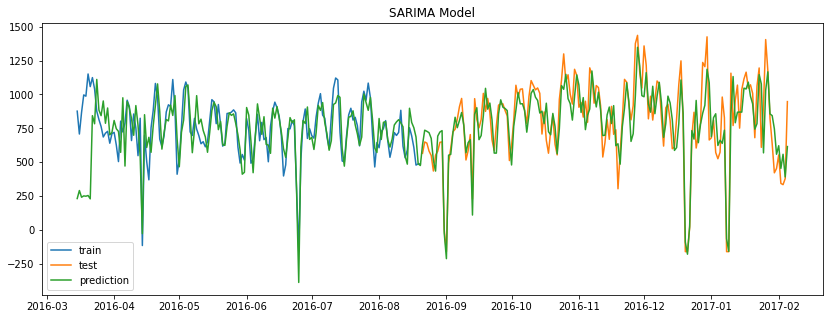

In [55]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data['Value'], label='train')
ax.plot(test_data['Value'], label='test')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [56]:
mae = mean_absolute_error(O['Value'], pred)
mape = mean_absolute_percentage_error(O['Value'], pred)
mse = mean_squared_error(O['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,126.490572,0.249889,31859.364806,178.491918


In [38]:
## define O test set
O_test = test_df.loc[test_df['Gas'] == "O3"]
O_test = O_test.drop(columns=['Gas'])

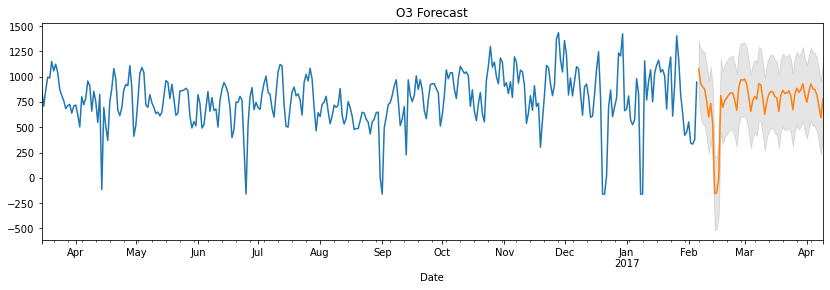

In [39]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=O_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = O['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("O3 Forecast")
plt.show()

#### After fitting the data into the SARIMAX model, we can see that an AIC score of 4131.765. We then plot the train data against the predicted data, and we can see that the prediction fits very closely with the train data. 
##### ‎
#### We then obtain some metrics of the model, and we see that we have obtained a RMSE of 178, which is decent.
##### ‎
#### Finally, we obtain an out-of-sample prediction of the next 63 days of values and plot the forecast plot. From the confidence intervals, we can see that although the true values may not be exactly the sme as the forecasted values, they will not go above or below the confidence intervals.
##  ‎

In [40]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=O_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('O3 Forecast.csv', index=False)

### Auto Arima

In [135]:
arima_model = auto_arima(train_data['Value'], seasonal=True, m=52, exog=exogO, n_jobs=-1)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  159
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -1040.242
Date:                            Thu, 04 Aug 2022   AIC                           2088.485
Time:                                    21:20:28   BIC                           2100.760
Sample:                                         0   HQIC                          2093.470
                                            - 159                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    457.3503     63.294      7.226      0.000     333.297     581.403
ar.L1          0.5005      0.053      9.411      0.000       0.396       0.605
ar.S.L52      -0.2329      0.094     -2.485      0.013      -0.417      -0.049
sigma2      2.764e+04   2281.470     12.114      0.000    2.32e+04    3.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               185.40
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
plot_train = train_data.drop(columns=['T', 'RH'])
plot_test = test_data.drop(columns=['T', 'RH'])

In [137]:
pred_in_sample = arima_model.predict_in_sample()
pred_out_sample = arima_model.predict(n_periods=169)
pred_full = np.concatenate((pred_in_sample, pred_out_sample))

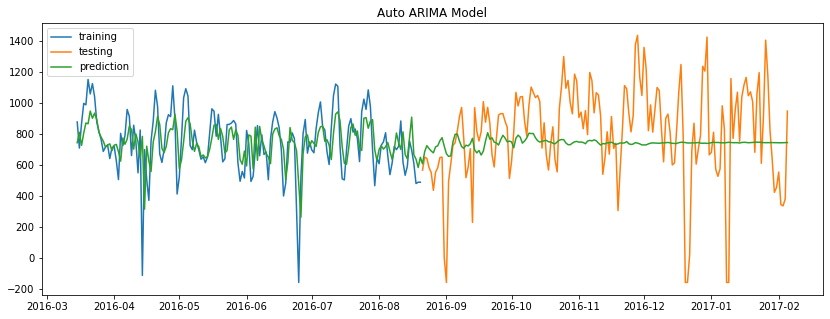

In [138]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(plot_train, label='training')
ax.plot(plot_test, label='testing')
ax.plot(NO.index, pred_full, label='prediction')
plt.legend()
plt.title('Auto ARIMA Model')
plt.show()

NOTES

1) we assume time series is additive
2) based on decomposition plot, seasonal component does not change with the changes in trend. hence 

### REFERENCES

#### https://dziganto.github.io/python/time%20series/Introduction-to-Time-Series/
#### https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
#### https://online.stat.psu.edu/stat510/lesson/5/5.1
#### https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced
#### https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
#### https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/